# Customer Compansation Drivers - VAR

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
import json


## 1. Prepare time series data

In [2]:
# Load data
df = pd.read_excel("data/dataset.xlsx", sheet_name='Modified Gross CPO Data')

# Ensure date is datetime
df['date'] = pd.to_datetime(df['date'])

# Sort by time
df = df.sort_values('date')
df = df.set_index('date')
df.head()

,Policy change 1,Policy change 2,Automation (%),Good Orders,Bad Orders,Undelivered Orders,Restaurant Count,Avg. End To End (mins),% End To End > 45 mins,% End To End > 60 mins,...,% Long Assignment Orders,% HQ Orders,Total Contact Propensity,Automation Contact Propensity,Advisor Contact Propensity,Customer Contact Propensity,Customer Compensation Propensity,Decline Rate,Gross CPE,Gross CPO
date,,,,,,,,,,,,,,,,,,,,,
2024-09-30,1,0,0.281982,1004435.0,18360.0,2912.0,21950.0,16.10,0.0665,0.018,...,0.0080,0.4100,0.0425,0.0210,0.0215,0.0400,0.0265,0.0780,4.335,0.2395
2024-10-07,1,0,0.290226,1106380.5,21589.0,2612.0,22229.0,16.10,0.0660,0.018,...,0.0085,0.4125,0.0395,0.0195,0.0200,0.0370,0.0240,0.1025,4.240,0.2145
2024-10-14,1,0,0.294271,1130292.0,22621.5,2544.5,26323.0,16.15,0.0675,0.019,...,0.0090,0.4125,0.0405,0.0205,0.0200,0.0380,0.0245,0.1150,4.145,0.2125
2024-10-21,1,0,0.293731,1142913.5,20269.0,2508.0,26851.0,15.60,0.0575,0.014,...,0.0055,0.4135,0.0380,0.0190,0.0190,0.0355,0.0230,0.1150,4.095,0.1980
2024-10-28,1,0,0.311397,1193250.0,24276.0,2731.0,27113.0,16.05,0.0660,0.018,...,0.0080,0.4105,0.0395,0.0215,0.0180,0.0370,0.0235,0.1120,3.775,0.1885


In [3]:
df.columns

Index(['Policy change 1', 'Policy change 2', 'Automation (%)', 'Good Orders',
       'Bad Orders', 'Undelivered Orders', 'Restaurant Count',
       'Avg. End To End (mins)', '% End To End > 45 mins',
       '% End To End > 60 mins', 'Avg. End To End excl McDonald's (mins)',
       'Avg. Placed to Delivered (mins)',
       'Avg. Customer Radius to Delivered (mins)',
       '% Bad + Undelivered Orders', '% Bad Orders', '% McD Recook', 'On Time',
       'Late', 'Early', 'Very Late', 'Very Early',
       'Post-order customer ETA accuracy (+/- 5 min)',
       '% Long Assignment Orders', '% HQ Orders', 'Total Contact Propensity',
       'Automation Contact Propensity', 'Advisor Contact Propensity',
       'Customer Contact Propensity', 'Customer Compensation Propensity',
       'Decline Rate', 'Gross CPE', 'Gross CPO'],
      dtype='object')

## 2. Visual check for stationarity

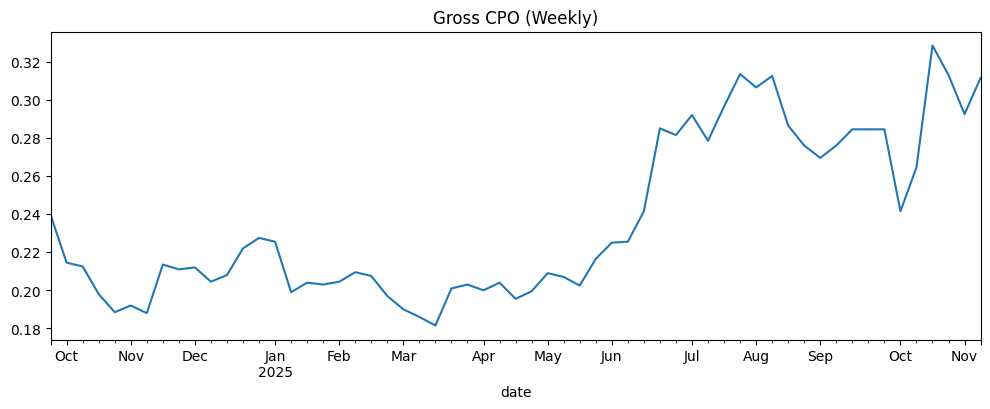

In [4]:
df['Gross CPO'].plot(figsize=(12,4), title="Gross CPO (Weekly)")
plt.show()

__Findings__:
* __Phase 1 - Oct 2024 to Mar 2025__: Relatively stable around 0.20–0.22
* __Phase 2 - Apr 2025 to mid-Jun 2025__: Slight dip to ~0.18 then slow rise
* __Phase 3 - Late Jun 2025 onward__: Sharp upward trend jumping significantly above 0.28

The upward shift is a level change.
The mean before June and after June are objectively different.

This violates the assumption of stationarity.

## 3. Feature selection for temporal modelling

### Data Leakage / Target Leakage
Exclude all post-order contact, compensation, and ETA accuracy metrics:
* _Total Contact Propensity_
* _Automation Contact Propensity_
* _Advisor Contact Propensity_
* _Customer Contact Propensity_
* _Customer Compensation Propensity_
* _Decline Rate_
* _Gross CPE_
* _Gross CPO_ (target itself)

Exclude post-order timeliness classifications:
* _On Time_
* _Late_
* _Early_
* _Very Late_
* _Very Early_
* _Post-order customer ETA accuracy (+/- 5 min)_

These metrics are effects, not causes.


### Duplication/Perfect Correlation

Exclude _% Bad Orders_ and _Undelivered Orders_
* If already represented inside _% Bad + Undelivered Orders_.
* Causes multicollinearity.

Exclude _Avg. End to End_ and _Avg. Placed to Delivered_
* Duplicates - both describe the same duration.

Exclude metrics that are transformations of others:
* _% End To End > 45 mins_
* _% End To End > 60 mins_
* _Avg. End To End excl Brand 1_

These are nonlinear partitions of overall speed metrics. Keep one clean lag-time signal (e.g., _Avg. End-to-End_) to avoid clutter.

Exclude _% Brand 1 Recook_
* If Brand 1 volume is small, this injects noise and collinearity with Bad Orders.

### Circularity

_Good Orders_
* Gross CPO = compensation / good orders
* Including _Good Orders_ as a driver creates mathematical dependence. This is a bad modelling practice.

### True Drivers

In [5]:
drivers = [
"Policy change 1", "Policy change 2", "Automation (%)", "Bad Orders", "Undelivered Orders", "Restaurant Count", 
    "Avg. Customer Radius to Delivered (mins)", "% Long Assignment Orders", "% HQ Orders", "Avg. End To End (mins)"
]

# choose Bad Orders or % Bad + Undelivered
# choose Undelivered Orders if not using the combined % metric

ts_df = df[['Gross CPO'] + drivers]
ts_df.head()

,Gross CPO,Policy change 1,Policy change 2,Automation (%),Bad Orders,Undelivered Orders,Restaurant Count,Avg. Customer Radius to Delivered (mins),% Long Assignment Orders,% HQ Orders,Avg. End To End (mins)
date,,,,,,,,,,,
2024-09-30,0.2395,1,0,0.281982,18360.0,2912.0,21950.0,0.95,0.0080,0.4100,16.10
2024-10-07,0.2145,1,0,0.290226,21589.0,2612.0,22229.0,0.95,0.0085,0.4125,16.10
2024-10-14,0.2125,1,0,0.294271,22621.5,2544.5,26323.0,0.95,0.0090,0.4125,16.15
2024-10-21,0.1980,1,0,0.293731,20269.0,2508.0,26851.0,0.95,0.0055,0.4135,15.60
2024-10-28,0.1885,1,0,0.311397,24276.0,2731.0,27113.0,0.95,0.0080,0.4105,16.05


## 4. Check stationarity using ADF test

In [6]:
from statsmodels.tsa.stattools import adfuller

for col in ts_df.columns:
    result = adfuller(ts_df[col].dropna())
    print(col, result[1])

Gross CPO 0.9197490624196993
Policy change 1 0.8332377238401021
Policy change 2 0.0062215008269728995
Automation (%) 0.7901211148007954
Bad Orders 0.8395860705146461
Undelivered Orders 0.00036148575773852523
Restaurant Count 5.5653894203463134e-12
Avg. Customer Radius to Delivered (mins) 0.017523588418377516
% Long Assignment Orders 0.556388212756566
% HQ Orders 0.1827433718645633
Avg. End To End (mins) 0.3562323295584343


C:\Users\haerb\anaconda3\envs\spacy_nlp_3.10_env\lib\site-packages\statsmodels\regression\linear_model.py:955: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


* p-value < 0.05 → stationary
* p-value ≥ 0.05 → difference column

In [7]:
ts_df_diff = ts_df.diff().dropna()

## 5. Fit a VAR model (multivariate AR model)

In [8]:
model = VAR(ts_df_diff)

# Select optimal lag length
lag_order = model.select_order(maxlags=3)
print(lag_order.summary())

best_lag = lag_order.selected_orders['aic']


 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0      -23.09     -22.69*   9.368e-11      -22.94
1      -23.89      -19.07   4.575e-11      -22.02
2      -24.45      -15.22   4.380e-11      -20.88
3     -31.22*      -17.57  2.710e-13*     -25.94*
-------------------------------------------------


C:\Users\haerb\anaconda3\envs\spacy_nlp_3.10_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


In [9]:
var_model = model.fit(best_lag)
print(var_model.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 07, Dec, 2025
Time:                     14:27:51
--------------------------------------------------------------------
No. of Equations:         11.0000    BIC:                   -17.5722
Nobs:                     55.0000    HQIC:                  -25.9436
Log likelihood:           374.149    FPE:                2.70954e-13
AIC:                     -31.2221    Det(Omega_mle):     1.36018e-15
--------------------------------------------------------------------
Results for equation Gross CPO
                                                 coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------------------------------
const                                               0.000680         0.003286            0.207           0.836
L1.Gross CPO                                   

## 6. Extract driver impact via Impulse Response Functions (IRF)

IRF answers the question:
“How does a shock (increase) in driver X affect Gross CPO over the next weeks?”

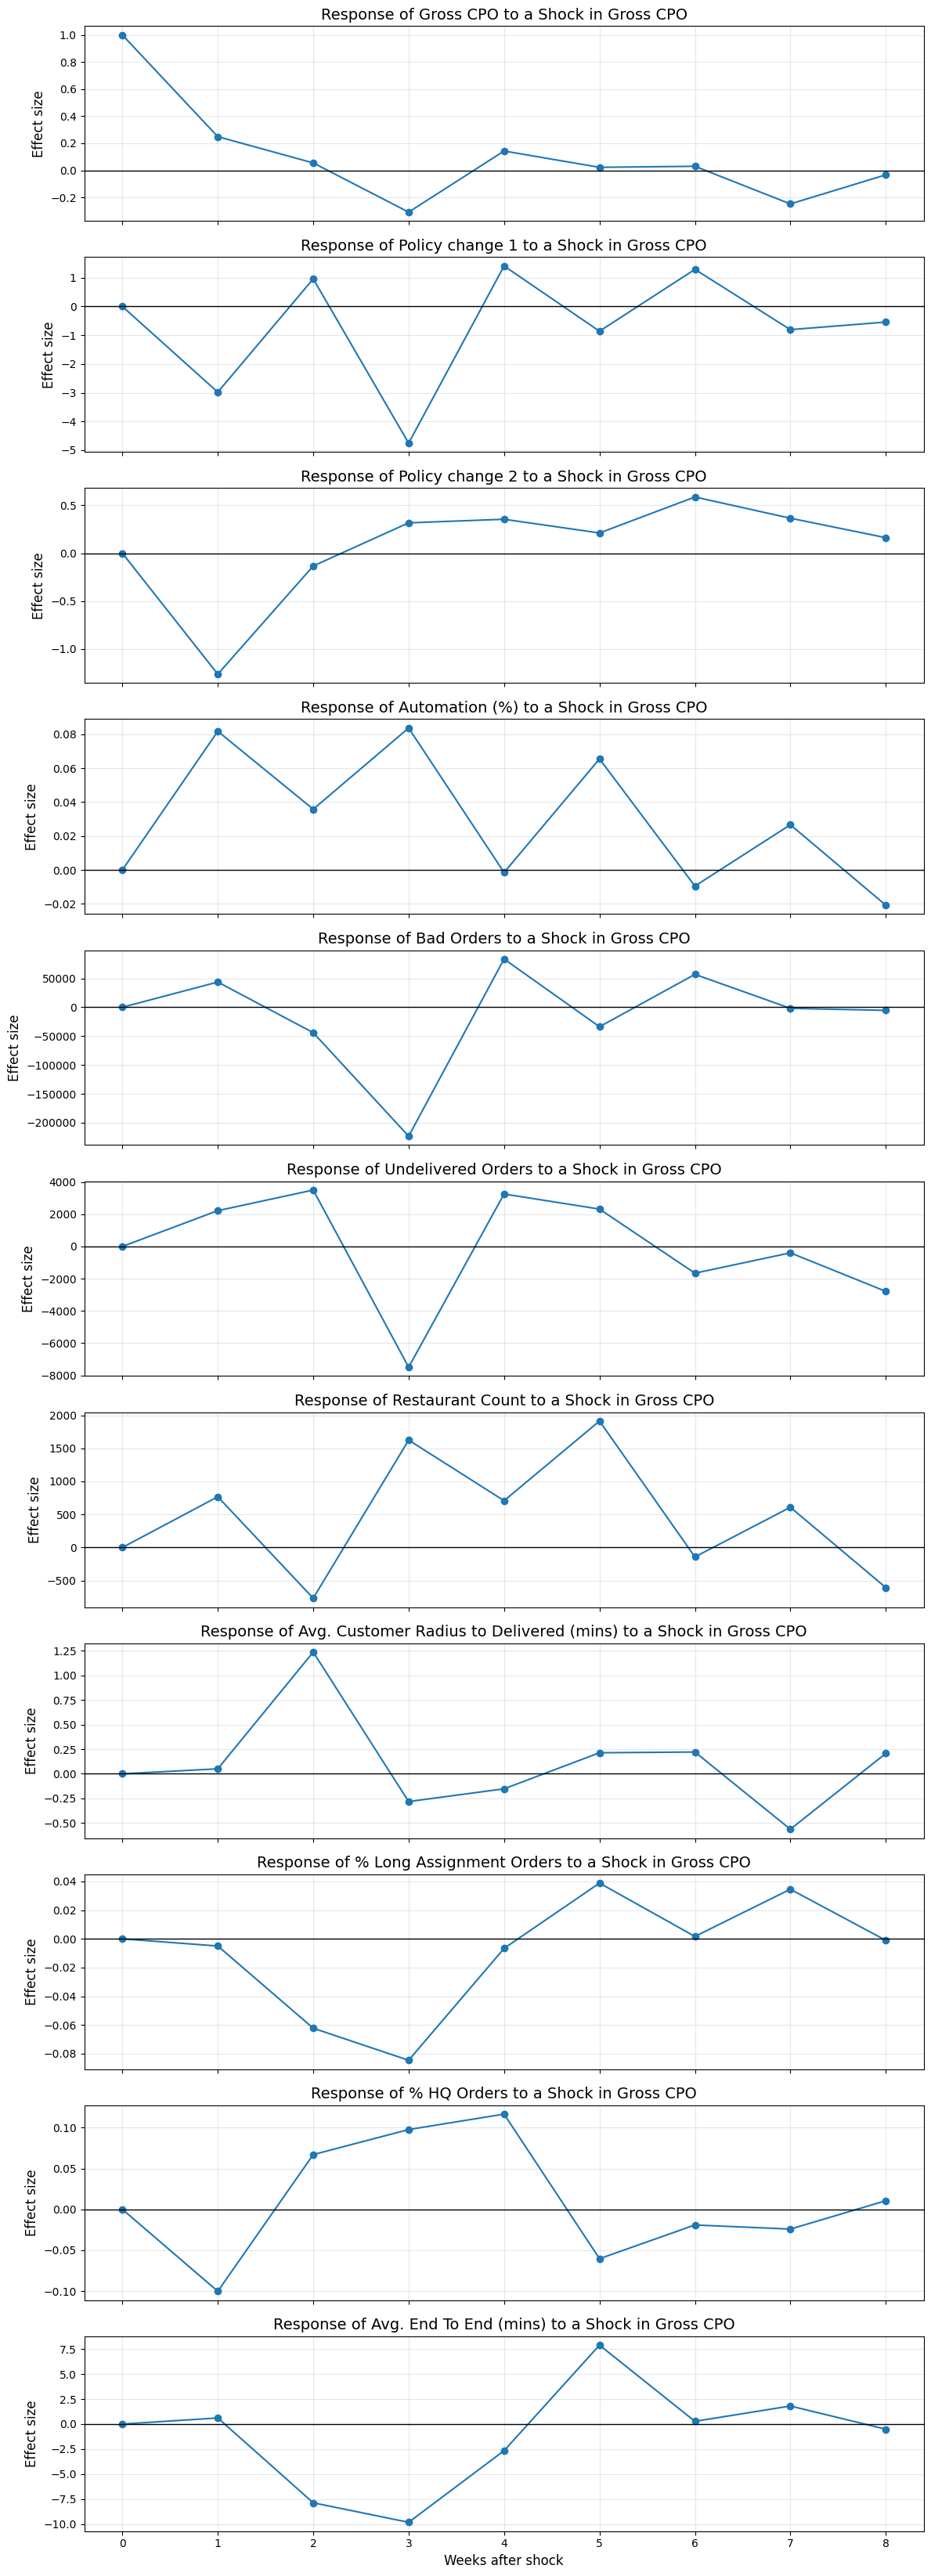

In [10]:
# Generate IRF object (example: 8-step horizon)
irf = var_model.irf(8)

# Extract IRF arrays
# irf.irfs shape = (steps+1, n_variables, n_variables)
irf_array = irf.irfs  
steps, k, _ = irf_array.shape

variables = ts_df_diff.columns.tolist()

# Create readable subplots
fig, axes = plt.subplots(nrows=k, ncols=1, figsize=(12, 3*k), sharex=True)

if k == 1:
    axes = [axes]  # handle single variable case

response_dict ={}
for i, ax in enumerate(axes):
    # IRF of "shock in Gross CPO" on variable i
    response = irf_array[:, i, variables.index('Gross CPO')] 
    response_dict[variables[i]]=response
    
    ax.plot(response, marker="o")
    ax.axhline(0, color='black', linewidth=1)
    ax.set_title(f"Response of {variables[i]} to a Shock in Gross CPO", fontsize=14)
    # ax.set_title(f"Impulse Response: Shock to Gross CPO → {variables[i]}", fontsize=14)
    ax.set_ylabel("Effect size", fontsize=12)
    ax.grid(alpha=0.3)

axes[-1].set_xlabel("Weeks after shock", fontsize=12)

plt.tight_layout()
plt.show()


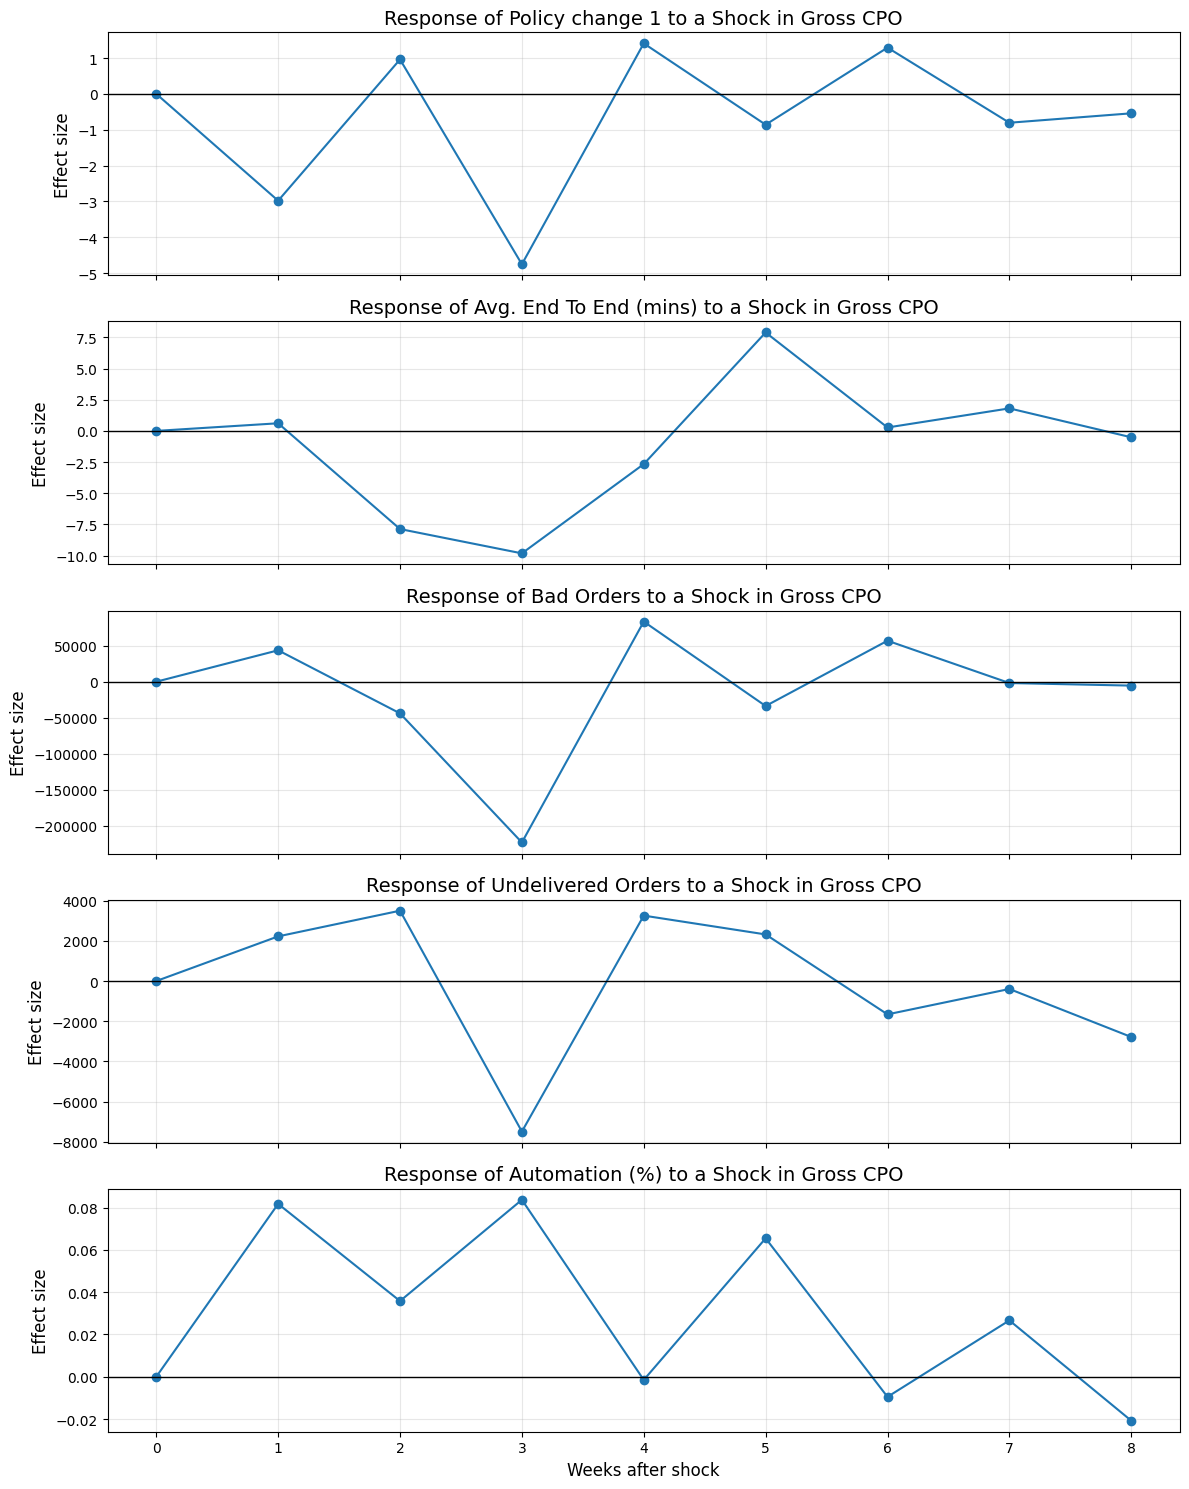

In [11]:
# Choose which variables you want to plot
selected_vars = ['Policy change 1', 'Avg. End To End (mins)', 'Bad Orders', 'Undelivered Orders', 'Automation (%)']

selected_indices = [variables.index(v) for v in selected_vars]

fig, axes = plt.subplots(
    nrows=len(selected_indices),
    ncols=1,
    figsize=(12, 3 * len(selected_indices)),
    sharex=True
)

if len(selected_indices) == 1:
    axes = [axes]

for ax, resp_idx in zip(axes, selected_indices):

    # Shock is always Gross CPO
    shock_idx = variables.index('Gross CPO')

    # IRF array assumed shape: [time, response, shock]
    response = irf_array[:, resp_idx, shock_idx]
    
    response_dict[variables[resp_idx]] = response

    ax.plot(response, marker="o")
    ax.axhline(0, color='black', linewidth=1)
    
    ax.set_title(
        f"Response of {variables[resp_idx]} to a Shock in Gross CPO",
        
        fontsize=14
    )
    ax.set_ylabel("Effect size", fontsize=12)
    ax.grid(alpha=0.3)

axes[-1].set_xlabel("Weeks after shock", fontsize=12)
plt.tight_layout()
plt.show()



__Findings__:

1. Gross CPO → Policy Change 1
* Policy Change 1 appears to be a reactive mechanism. When CPO spikes, the system quickly pulls back (negative values), possibly tightening rules or reinstating controls.
* Later overshoot suggests temporary over-correction. This looks like a corrective operational policy cycle.

2. Gross CPO → Policy Change 2
* A CPO increase leads to a reduction in Policy Change 2 metrics—suggesting this policy area may get “paused” or rolled back when costs increase, then slowly re-applied.
* Indicates policy throttling when compensation spikes.




## 7. Forecast Error Variance Decomposition (FEVD)

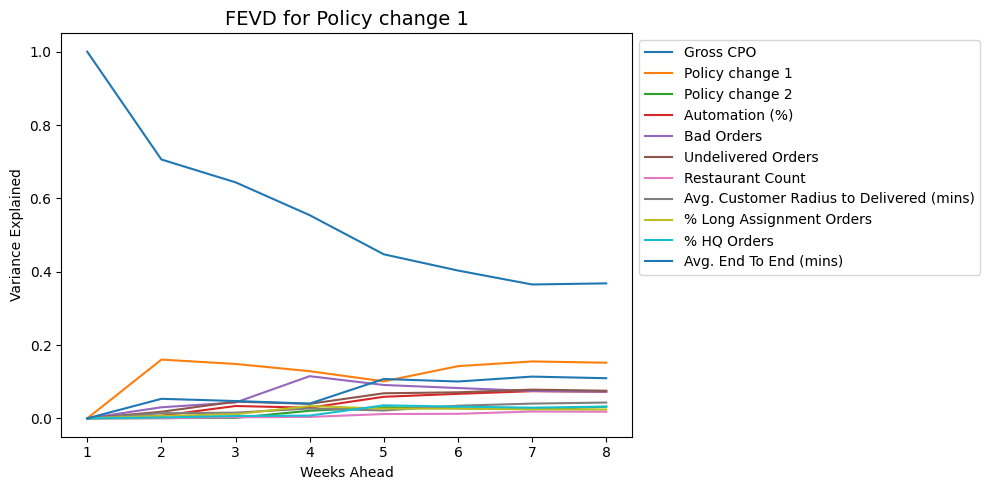

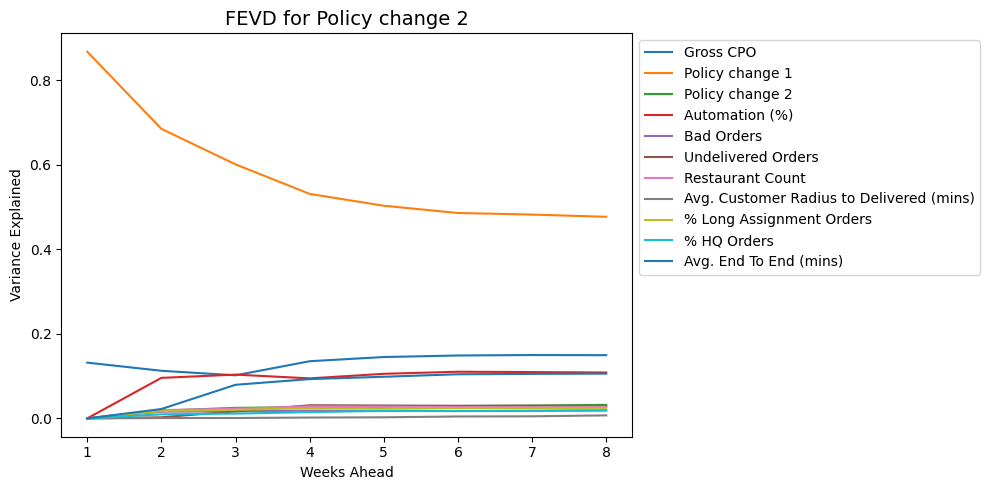

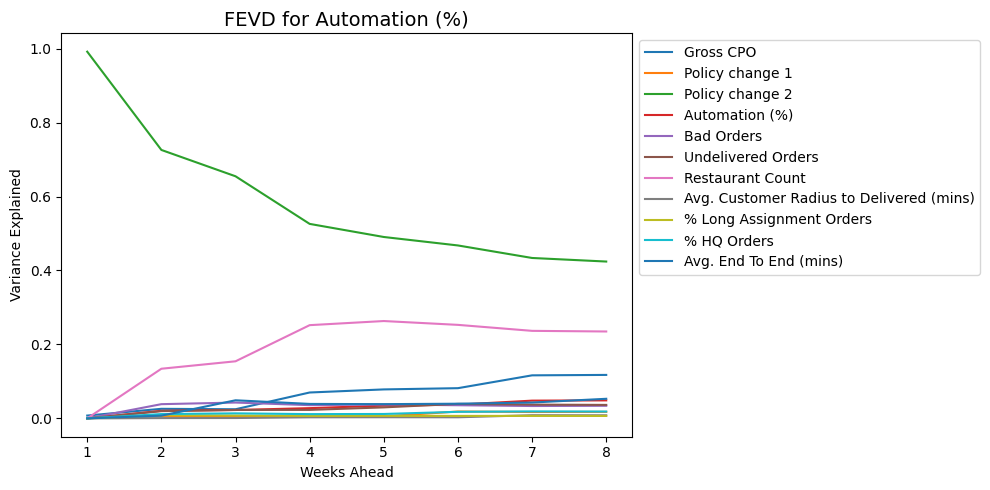

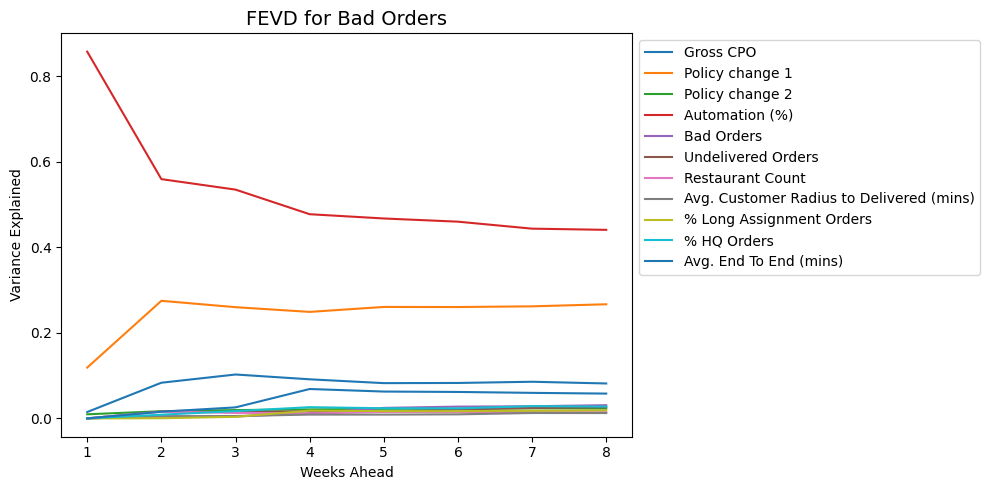

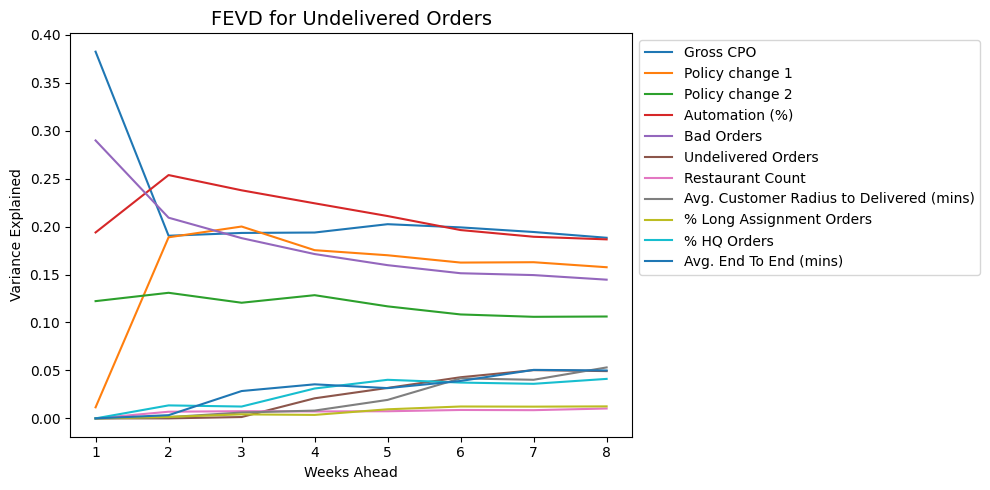

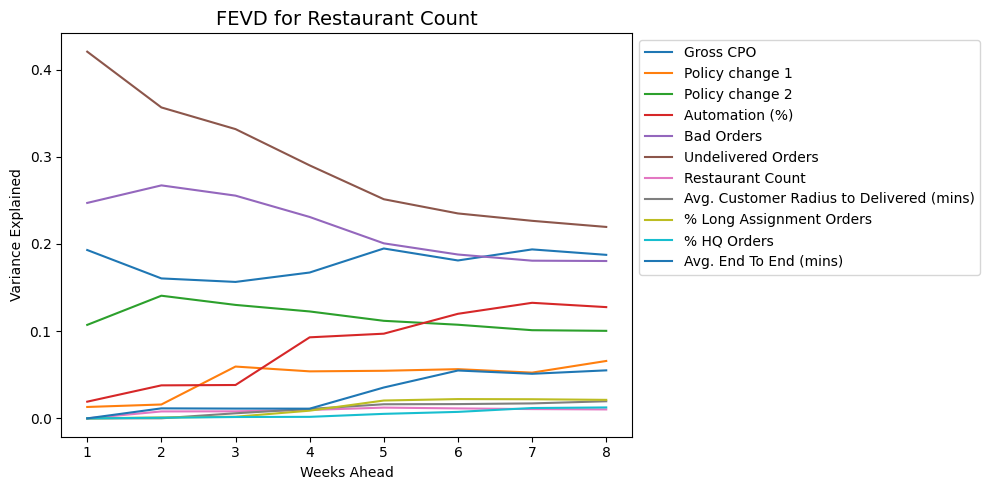

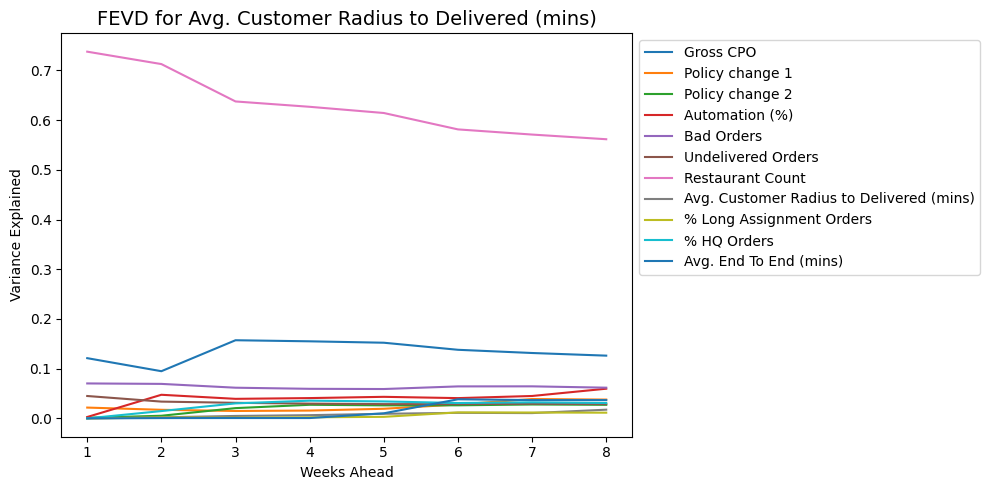

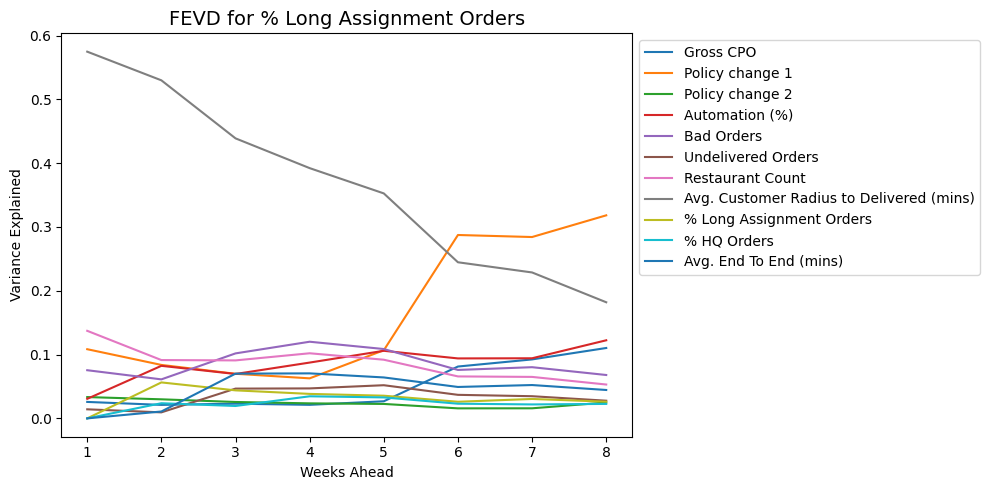

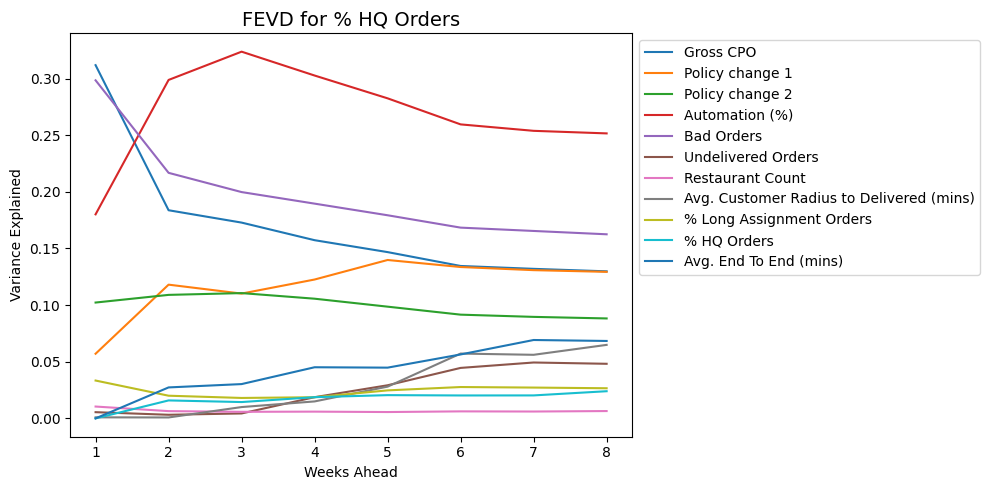

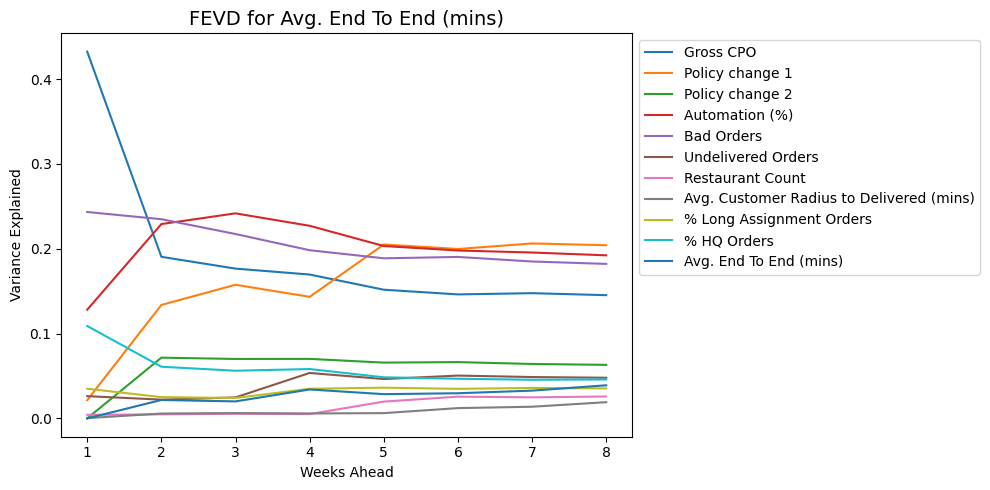

In [12]:
H = 8  # horizon
fevd = var_model.fevd(H)

variables = fevd.names
k = len(variables)

for i, var in enumerate(variables[1:]):
    
    contrib = fevd.decomp[i]        # shape (H, k)
    
    plt.figure(figsize=(10,5))
    
    for j in range(k):
        plt.plot(range(1, H+1), contrib[:, j], label=variables[j])
    
    plt.title(f"FEVD for {var}", fontsize=14)
    plt.xlabel("Weeks Ahead")
    plt.ylabel("Variance Explained")
    plt.legend(loc='upper left', bbox_to_anchor=(1,1))
    plt.tight_layout()
    plt.show()


### 7.1 Extract FEVD Driver Contributions (8-week horizon)

In [13]:
H = 8   # horizon used in your FEVD
fevd = var_model.fevd(H)

# driver names
variables = fevd.names

# FEVD for Gross CPO is index 0 (assuming Gross CPO is first in VAR model)
gross_cpo_index = 0

# FEVD matrix: shape (horizon, num_variables)
fevd_matrix = fevd.decomp[gross_cpo_index]   # returns horizon × drivers

# Take the final horizon (most stable variance decomposition)
final_fevd = fevd_matrix[-1]

# Build ranking table
ranking_df = pd.DataFrame({
    'Driver': variables[1:],
    'Variance_Explained_at_Horizon_8': final_fevd[1:]
})

ranking_df = ranking_df.sort_values(
    by='Variance_Explained_at_Horizon_8',
    ascending=False
).reset_index(drop=True)

ranking_df

,Driver,Variance_Explained_at_Horizon_8
0,Policy change 1,0.151793
1,Avg. End To End (mins),0.109534
2,Undelivered Orders,0.075378
3,Bad Orders,0.072894
4,Automation (%),0.072710
5,Avg. Customer Radius to Delivered (mins),0.043189
6,% HQ Orders,0.032191
7,Policy change 2,0.031741
8,% Long Assignment Orders,0.024229
9,Restaurant Count,0.018177


__Note :__
- We use the FEVD plots for directional understanding, but we rely on the numeric extraction from the FEVD decomposition matrix to quantify driver importance. 
- The visual FEVD often under- or over-represents magnitude due to normalisation and axis scaling. 
- Therefore, the numeric FEVD contributions represent the true variance share explained by each driver.

## 8. Forecast

In [14]:
forecast = var_model.forecast(ts_df_diff.values[-best_lag:], steps=8)
forecast_df = pd.DataFrame(forecast, columns=ts_df_diff.columns)
forecast_df

,Gross CPO,Policy change 1,Policy change 2,Automation (%),Bad Orders,Undelivered Orders,Restaurant Count,Avg. Customer Radius to Delivered (mins),% Long Assignment Orders,% HQ Orders,Avg. End To End (mins)
0,0.007393,0.244010,-0.031166,-0.007614,4759.773268,903.435625,78.189877,0.063053,-0.003204,0.005821,-0.191520
1,-0.004908,-0.154129,-0.020964,0.001841,-5359.149677,-146.725869,43.671717,0.004291,-0.000371,-0.003733,-0.004024
2,0.003598,0.140569,0.051254,-0.004349,3466.593189,-247.050035,34.098494,-0.043188,-0.001430,0.006063,-0.405991
3,-0.026569,-0.154474,-0.006409,0.008322,-3813.153424,95.313833,87.029702,-0.056479,0.000298,-0.003514,0.063719
4,0.009850,0.020250,-0.007646,-0.001036,-672.573575,-98.302390,-36.943993,0.005702,-0.002129,-0.002668,-0.106372
5,0.004922,0.045385,0.008588,0.000785,6277.421019,194.472361,105.230805,0.001523,0.004057,-0.006891,0.548847
6,-0.006215,-0.040578,-0.003326,-0.002944,-1170.765686,-11.302487,5.209753,0.019986,-0.000464,0.002666,-0.206364
7,-0.002946,0.005051,-0.017566,0.004364,-986.773011,-36.762579,32.937318,-0.019168,-0.000775,0.002212,-0.131515
